In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moment

from utils import *
from AnalyseDefects import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll


from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler
from matplotlib import ticker
from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

In [5]:
def get_defect_arr_from_frame(defect_dict, signed=False):
    """
    Convert dictionary of defects to array of defect positions and charges (if signed). Format is: [x, y, charge]
    """
    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 2 + int(signed)])
    for i, defect in enumerate(defect_dict):
        defect_positions[i,:2] = defect['pos']
        if signed:
            defect_positions[i,2] = defect['charge']
    return defect_positions

def get_structure_factor_from_defect_list(defect_list, box_window, LX = None, \
                                          frame_interval = None, kmax = 1, \
                                            debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = len(defect_list) if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Initialize structure factor
    sf_arr = None

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        if defect_positions is None:
            continue

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        t1 = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
            
        t2 = time.time()
        if i%10 == 0:
            print("Time for structure factor: {}".format(t2 - t1))

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if sf_arr is None:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr

In [6]:
path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512vl_cl'

act = 0.022
Nexp = 10

act_path = os.path.join(path, f'analysis_zeta_{act}')

def_dict = {}

for i in range(Nexp):
    def_path = os.path.join(act_path, f'zeta_{act}_counter_{i}', 'defect_positions.pkl')

    with open(def_path, 'rb') as f:
        def_dict[f'df{i}'] = pickle.load(f)

In [15]:
def0 = def_dict['df0']
df_arr = get_defect_arr_from_frame(def0[0], signed=True)

In [55]:
mask = (def_arr[:,-1] > 0)
mask.sum(), mask.sum()/len(mask)

(43, 0.5)

In [7]:
LX = 512
window = BoxWindow(bounds=[[0, LX], [0, LX]])  
kbins, sfac_arr = get_structure_factor_from_defect_list(def_dict['df0'], window, LX = LX, frame_interval = [0, 100], kmax = .25, debiased = True, direct = True, nbins = 50)

Time for structure factor: 0.4917283058166504
Time for structure factor: 0.2757556438446045
Time for structure factor: 0.27852797508239746
Time for structure factor: 0.26789283752441406
Time for structure factor: 0.29192042350769043
Time for structure factor: 0.3126041889190674
Time for structure factor: 0.29483604431152344
Time for structure factor: 0.3120579719543457
Time for structure factor: 0.3619110584259033
Time for structure factor: 0.37125492095947266


<ErrorbarContainer object of 3 artists>

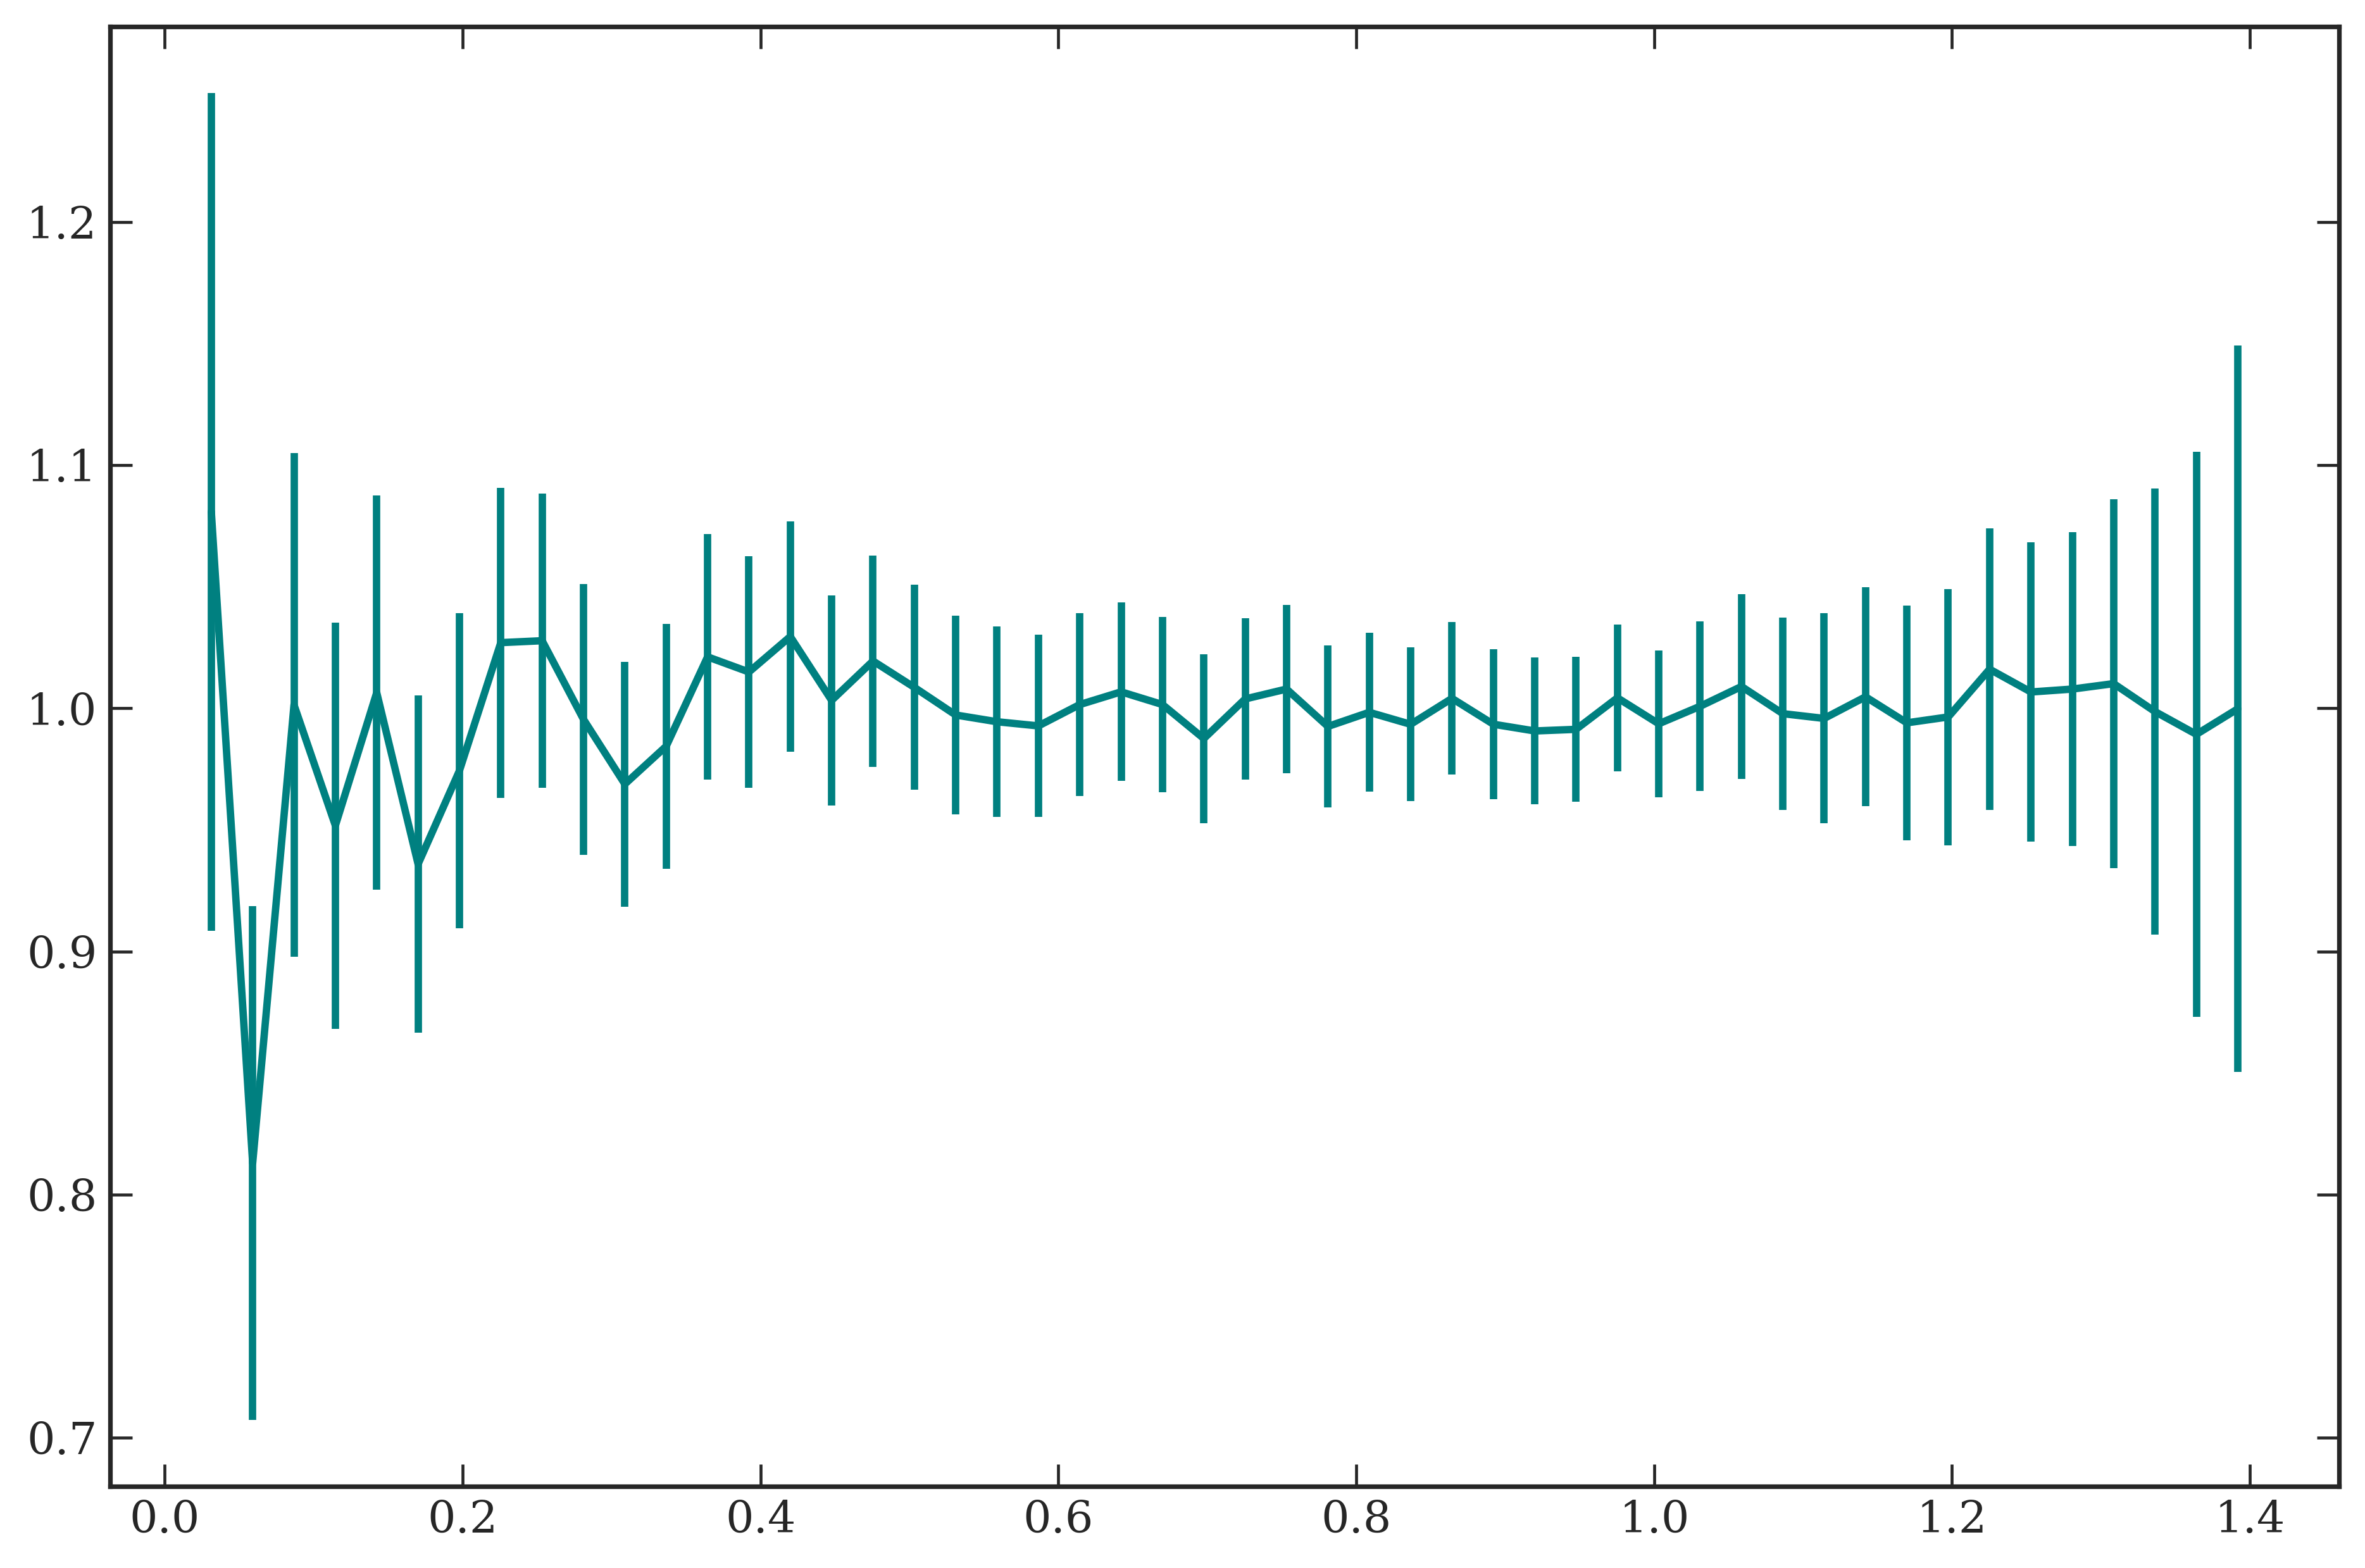

In [8]:
plt.errorbar(kbins, sfac_arr[:, :, 0].mean(axis=0), yerr=sfac_arr[:, :, 1].mean(axis=0))

In [72]:
# dist_list is now a list, where each element is a list of distances between defects in a single frame
# make a new list unpacking the inner lists
dist_list_new = [dist for dists in dist_list for dist in dists]


In [73]:
len(dist_list_new   )

2229732

In [76]:
pdf_uni = lambda r: 2*np.pi*r*np.exp(-np.pi*r**2)

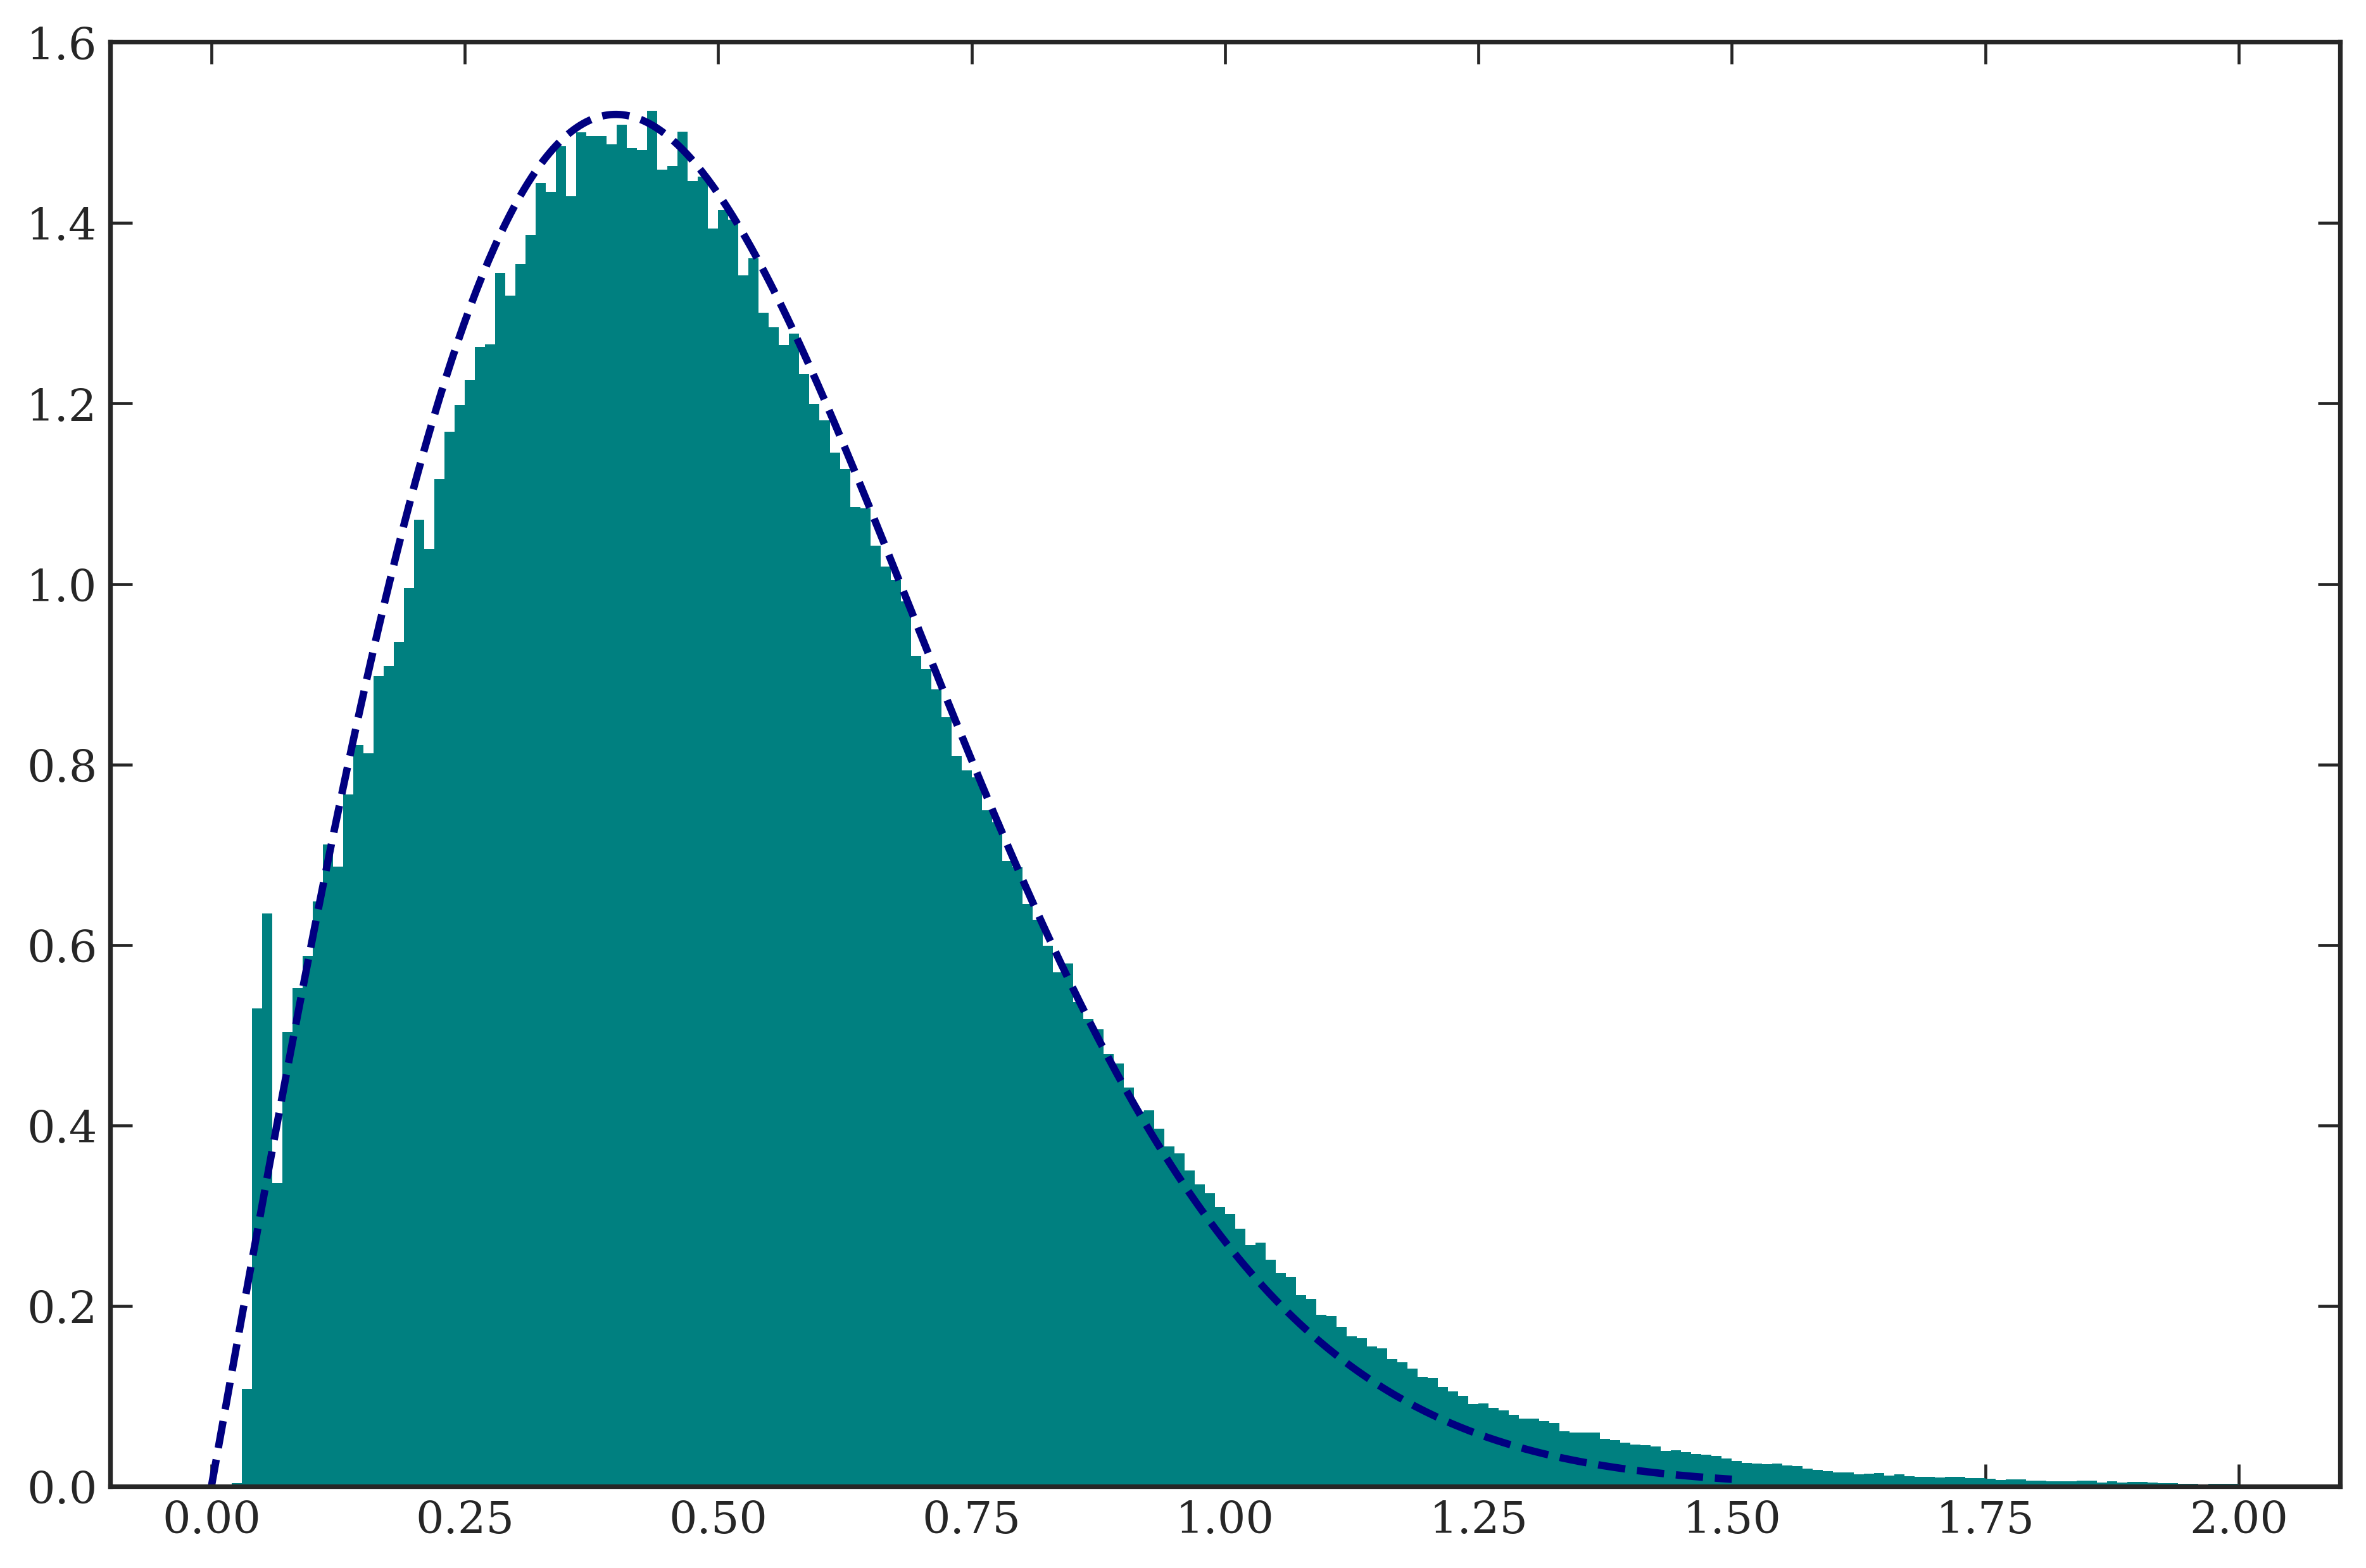

In [80]:
dist_list_new = [dist for dists in dist_list for dist in dists]
plt.hist(dist_list_new, bins=200, range=(0,2), density=True);
r_vals = np.linspace(0, 1.5, 500)
plt.plot(r_vals, pdf_uni(r_vals), '--') #*len(dist_list_new)*0.01)

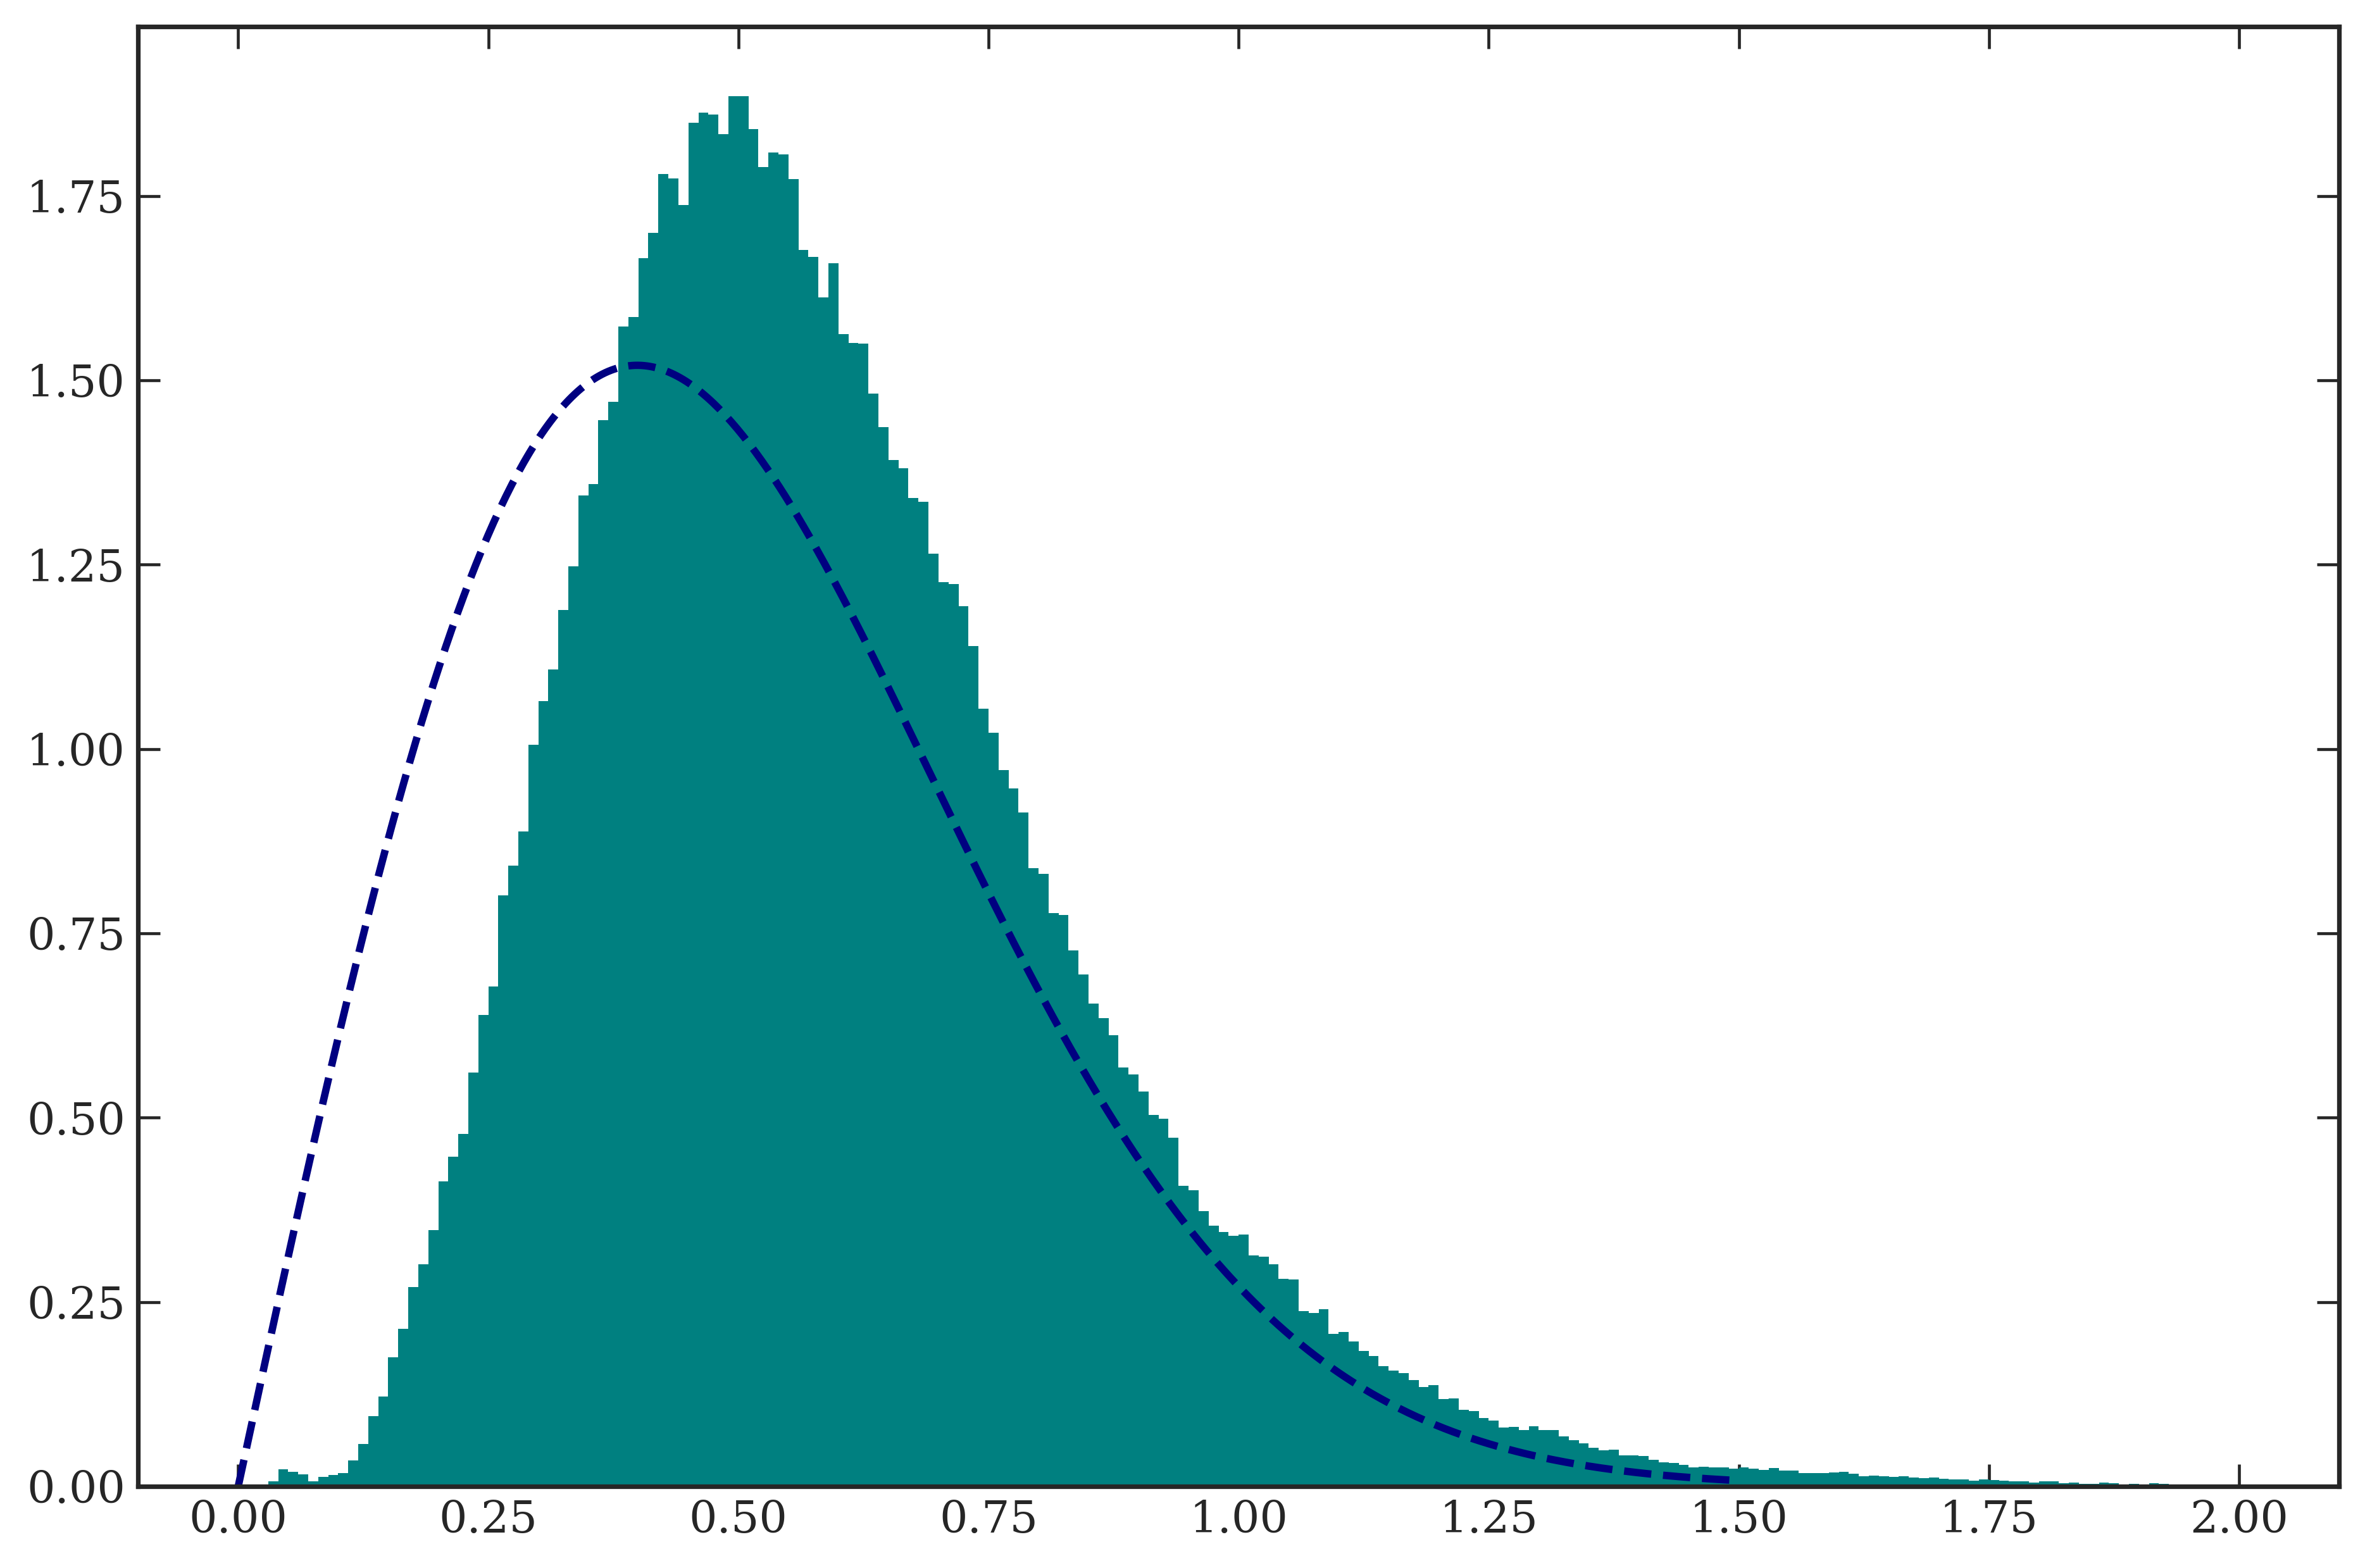

In [82]:
dist_list_new = [dist for dists in dist_list for dist in dists]
plt.hist(dist_list_new, bins=200, range=(0,2), density=True);
r_vals = np.linspace(0, 1.5, 500)
plt.plot(r_vals, pdf_uni(r_vals), '--') #*len(dist_list_new)*0.01)

In [81]:
nn_arr = np.empty([len(def0), 3, Nexp])
LX = 512

dist_list = []

mask = True

for j, key in enumerate(def_dict.keys()):
    def0 = def_dict[key]
    for i, frame in enumerate(def0):
        def_arr = get_defect_arr_from_frame(frame, signed=True)

        if mask:
            def_arr = def_arr[def_arr[:,-1] < 0]

        tree = KDTree(def_arr[:,:2])
        dist, _ = tree.query(def_arr[:,:2], k = 2)

        nn_arr[i,0,j] = dist[:,1].mean()
        nn_arr[i,1,j] = dist[:,1].std(ddof=1)
        nn_arr[i,2,j] = LX/np.sqrt(dist.shape[0])

        dist_list.append(dist[:,1] / (LX/np.sqrt(dist.shape[0])))

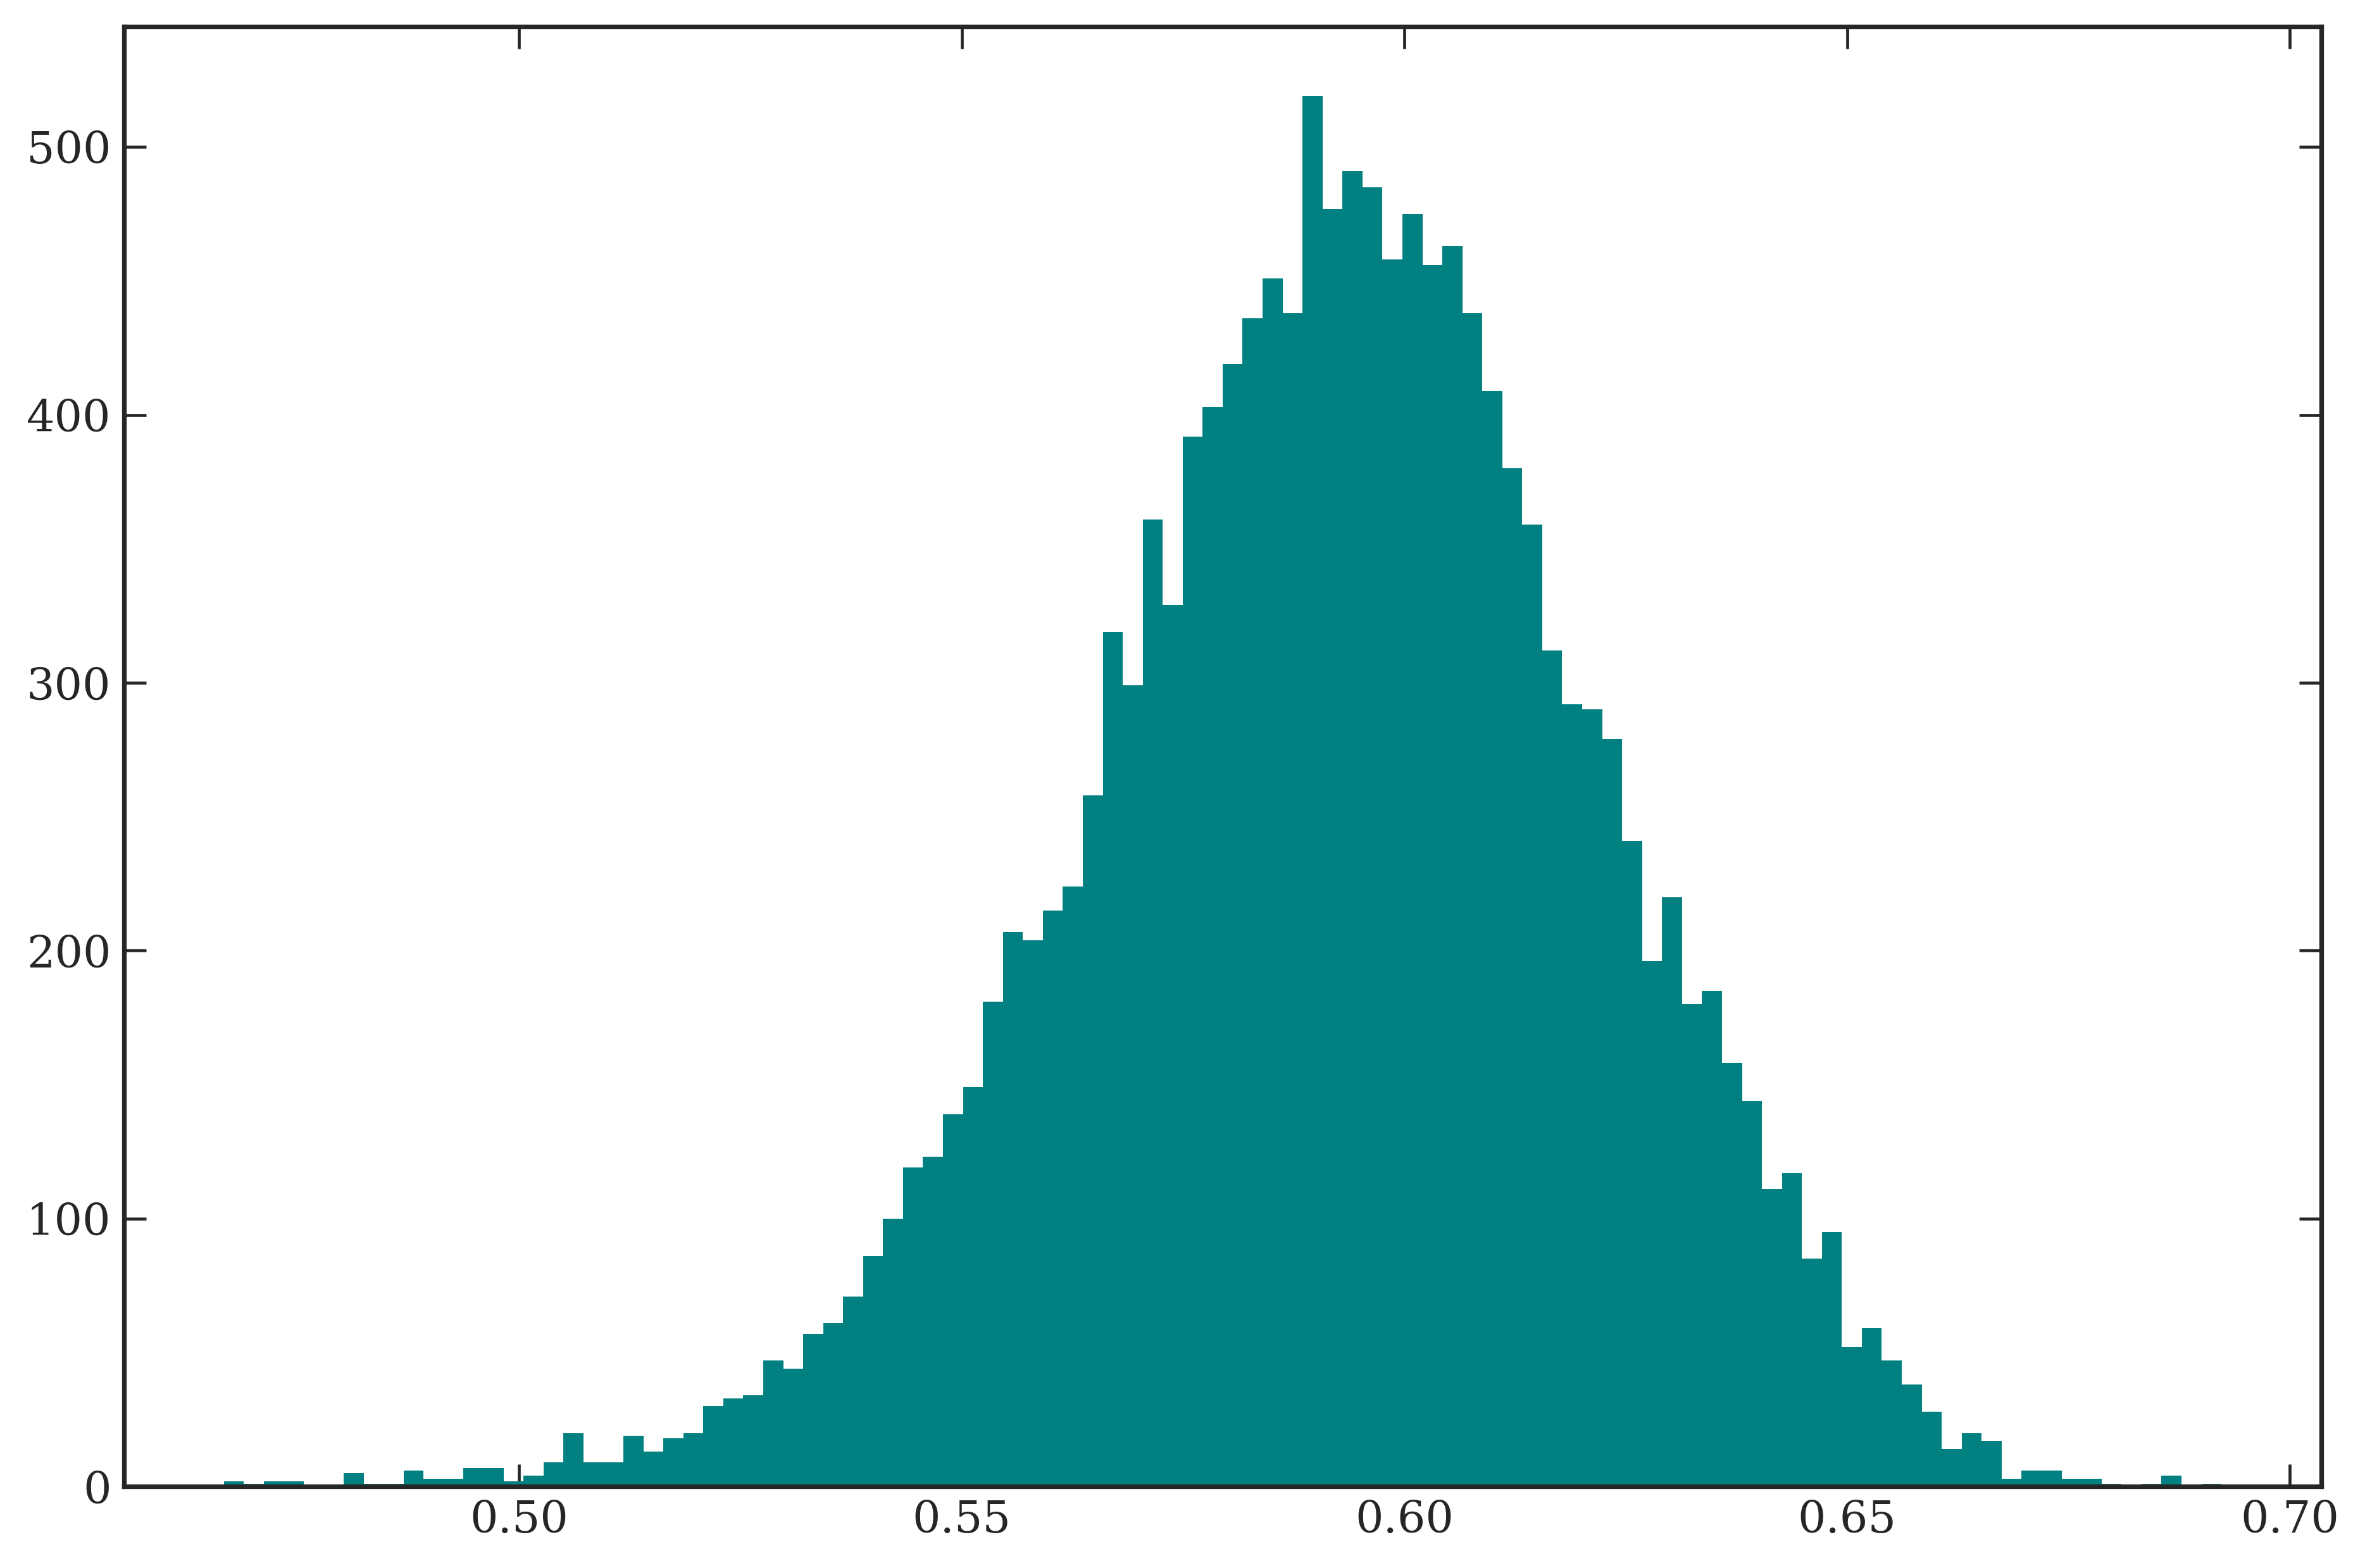

In [59]:
plt.hist((nn_arr[:,0,:] /nn_arr[:,-1,:]).flatten(), bins=100);

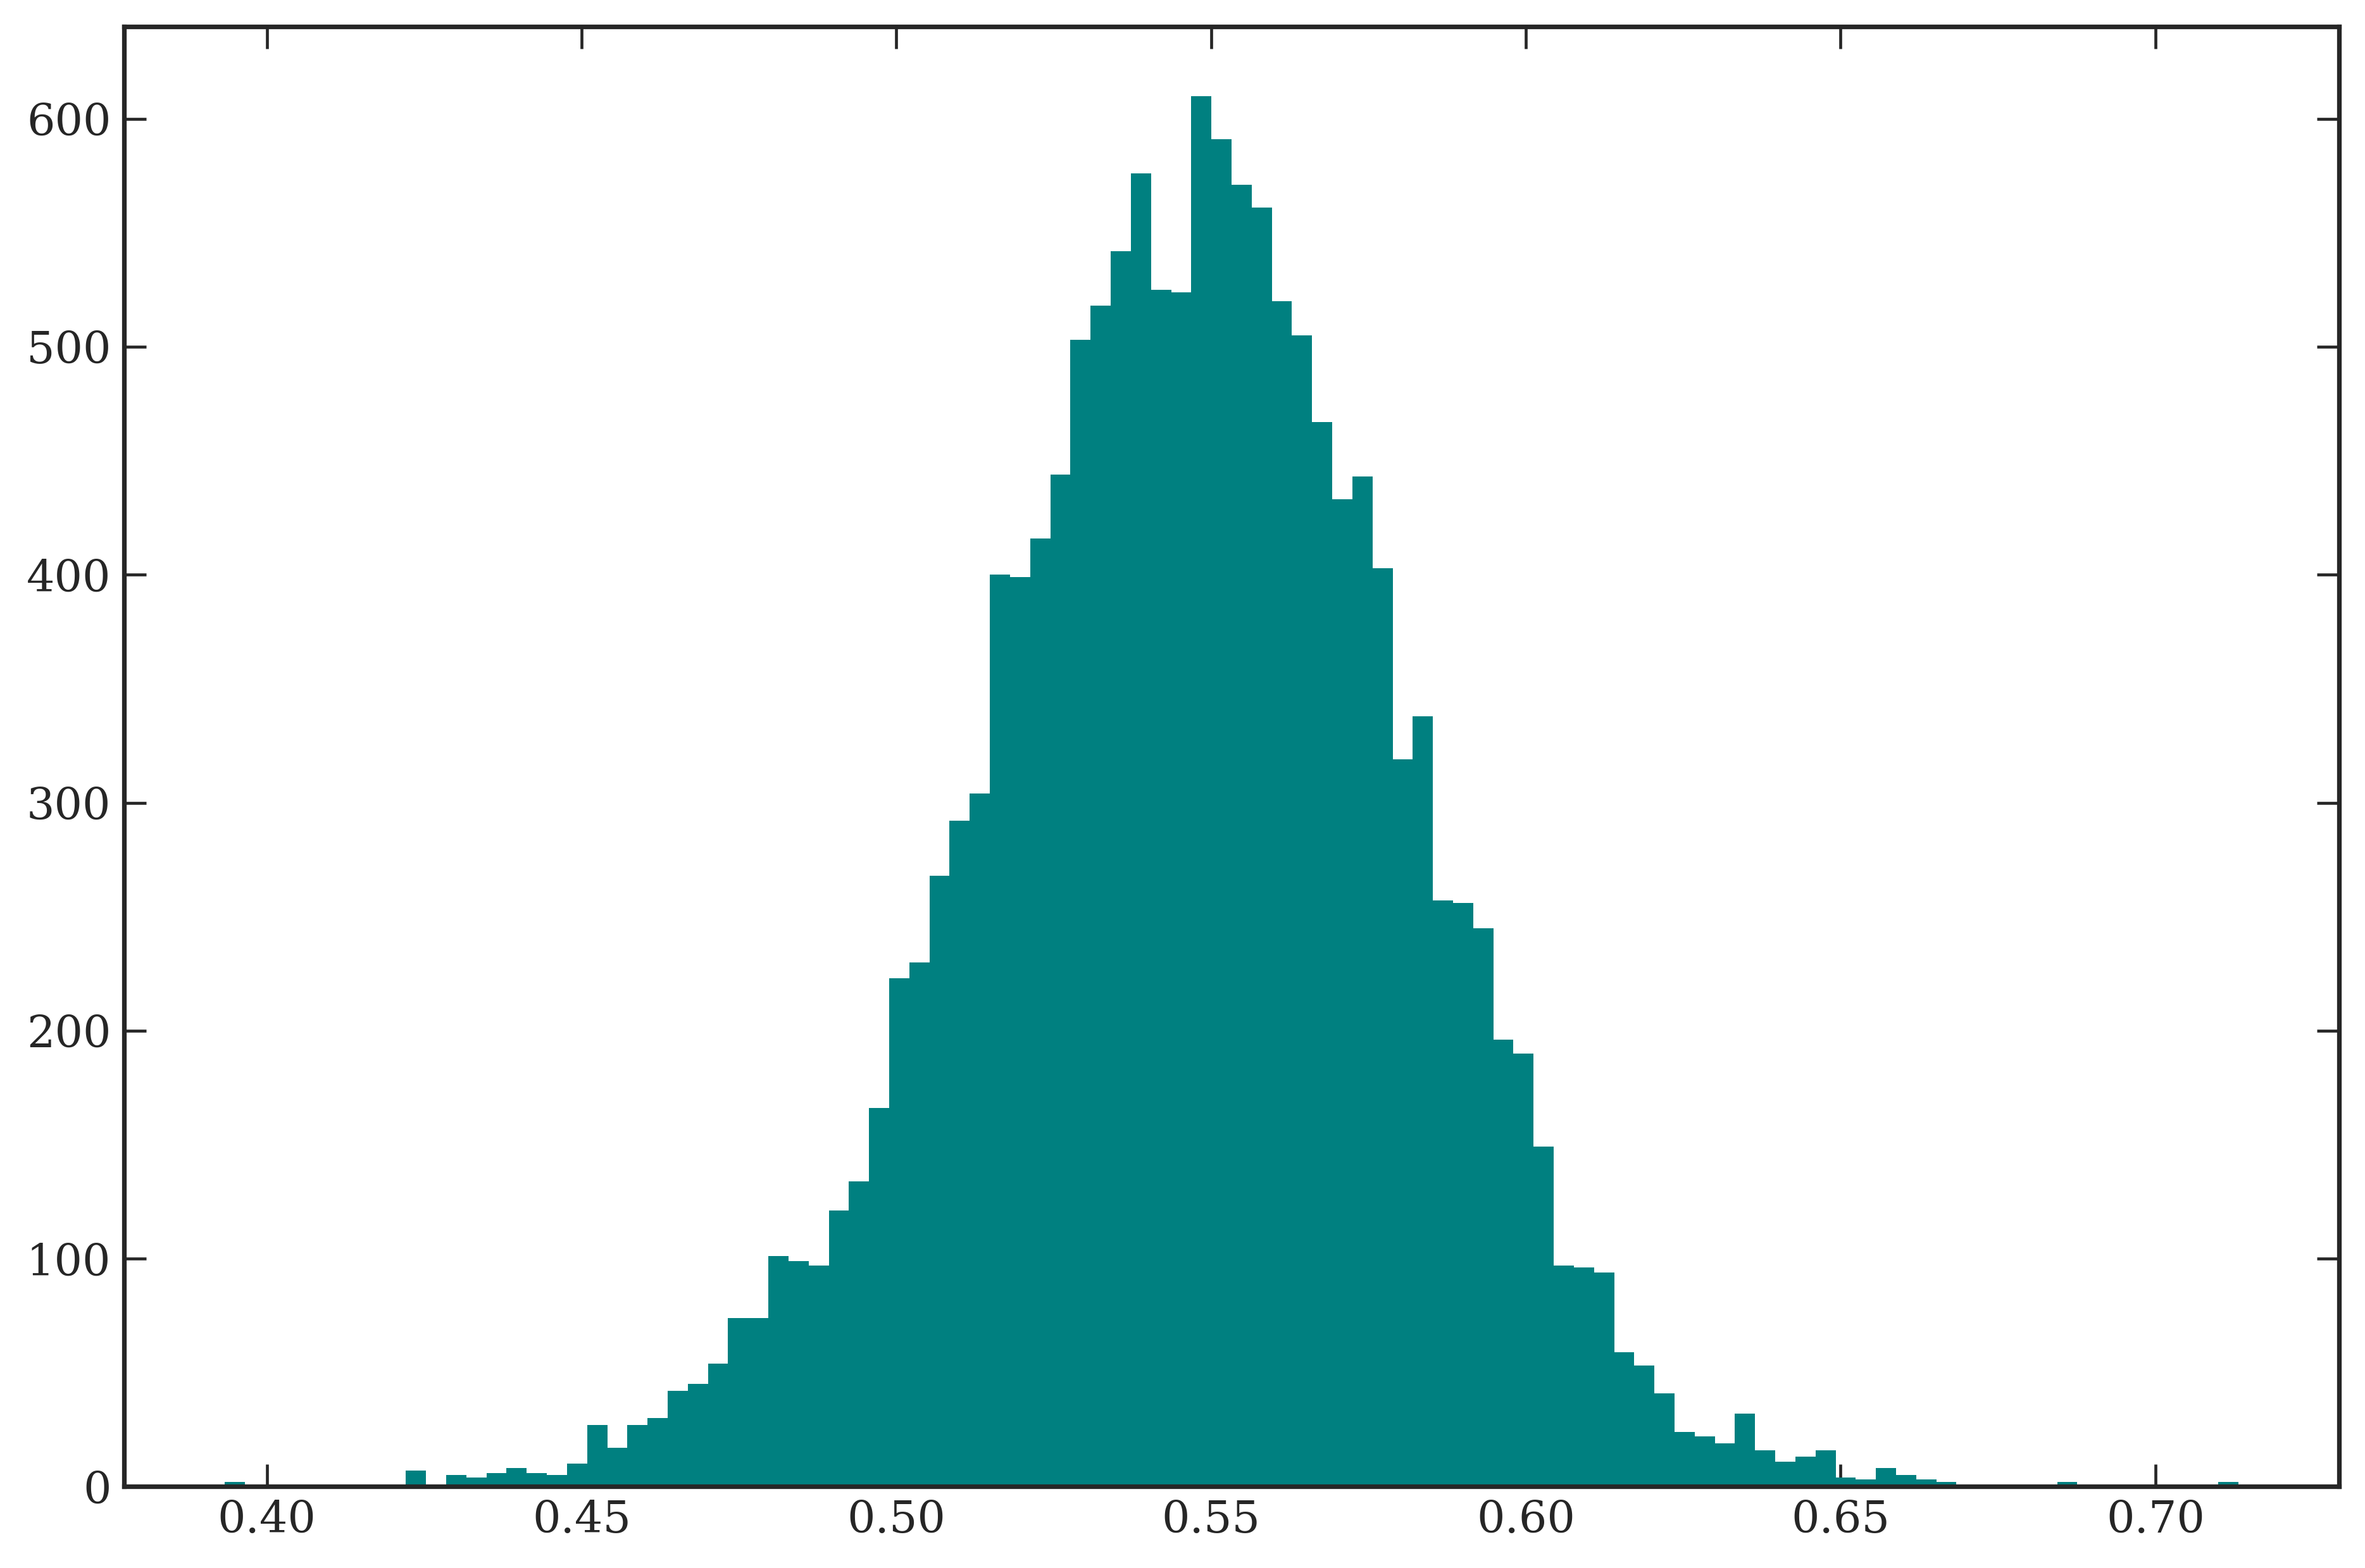

In [57]:
plt.hist((nn_arr[:,0,:] /nn_arr[:,-1,:]).flatten(), bins=100);

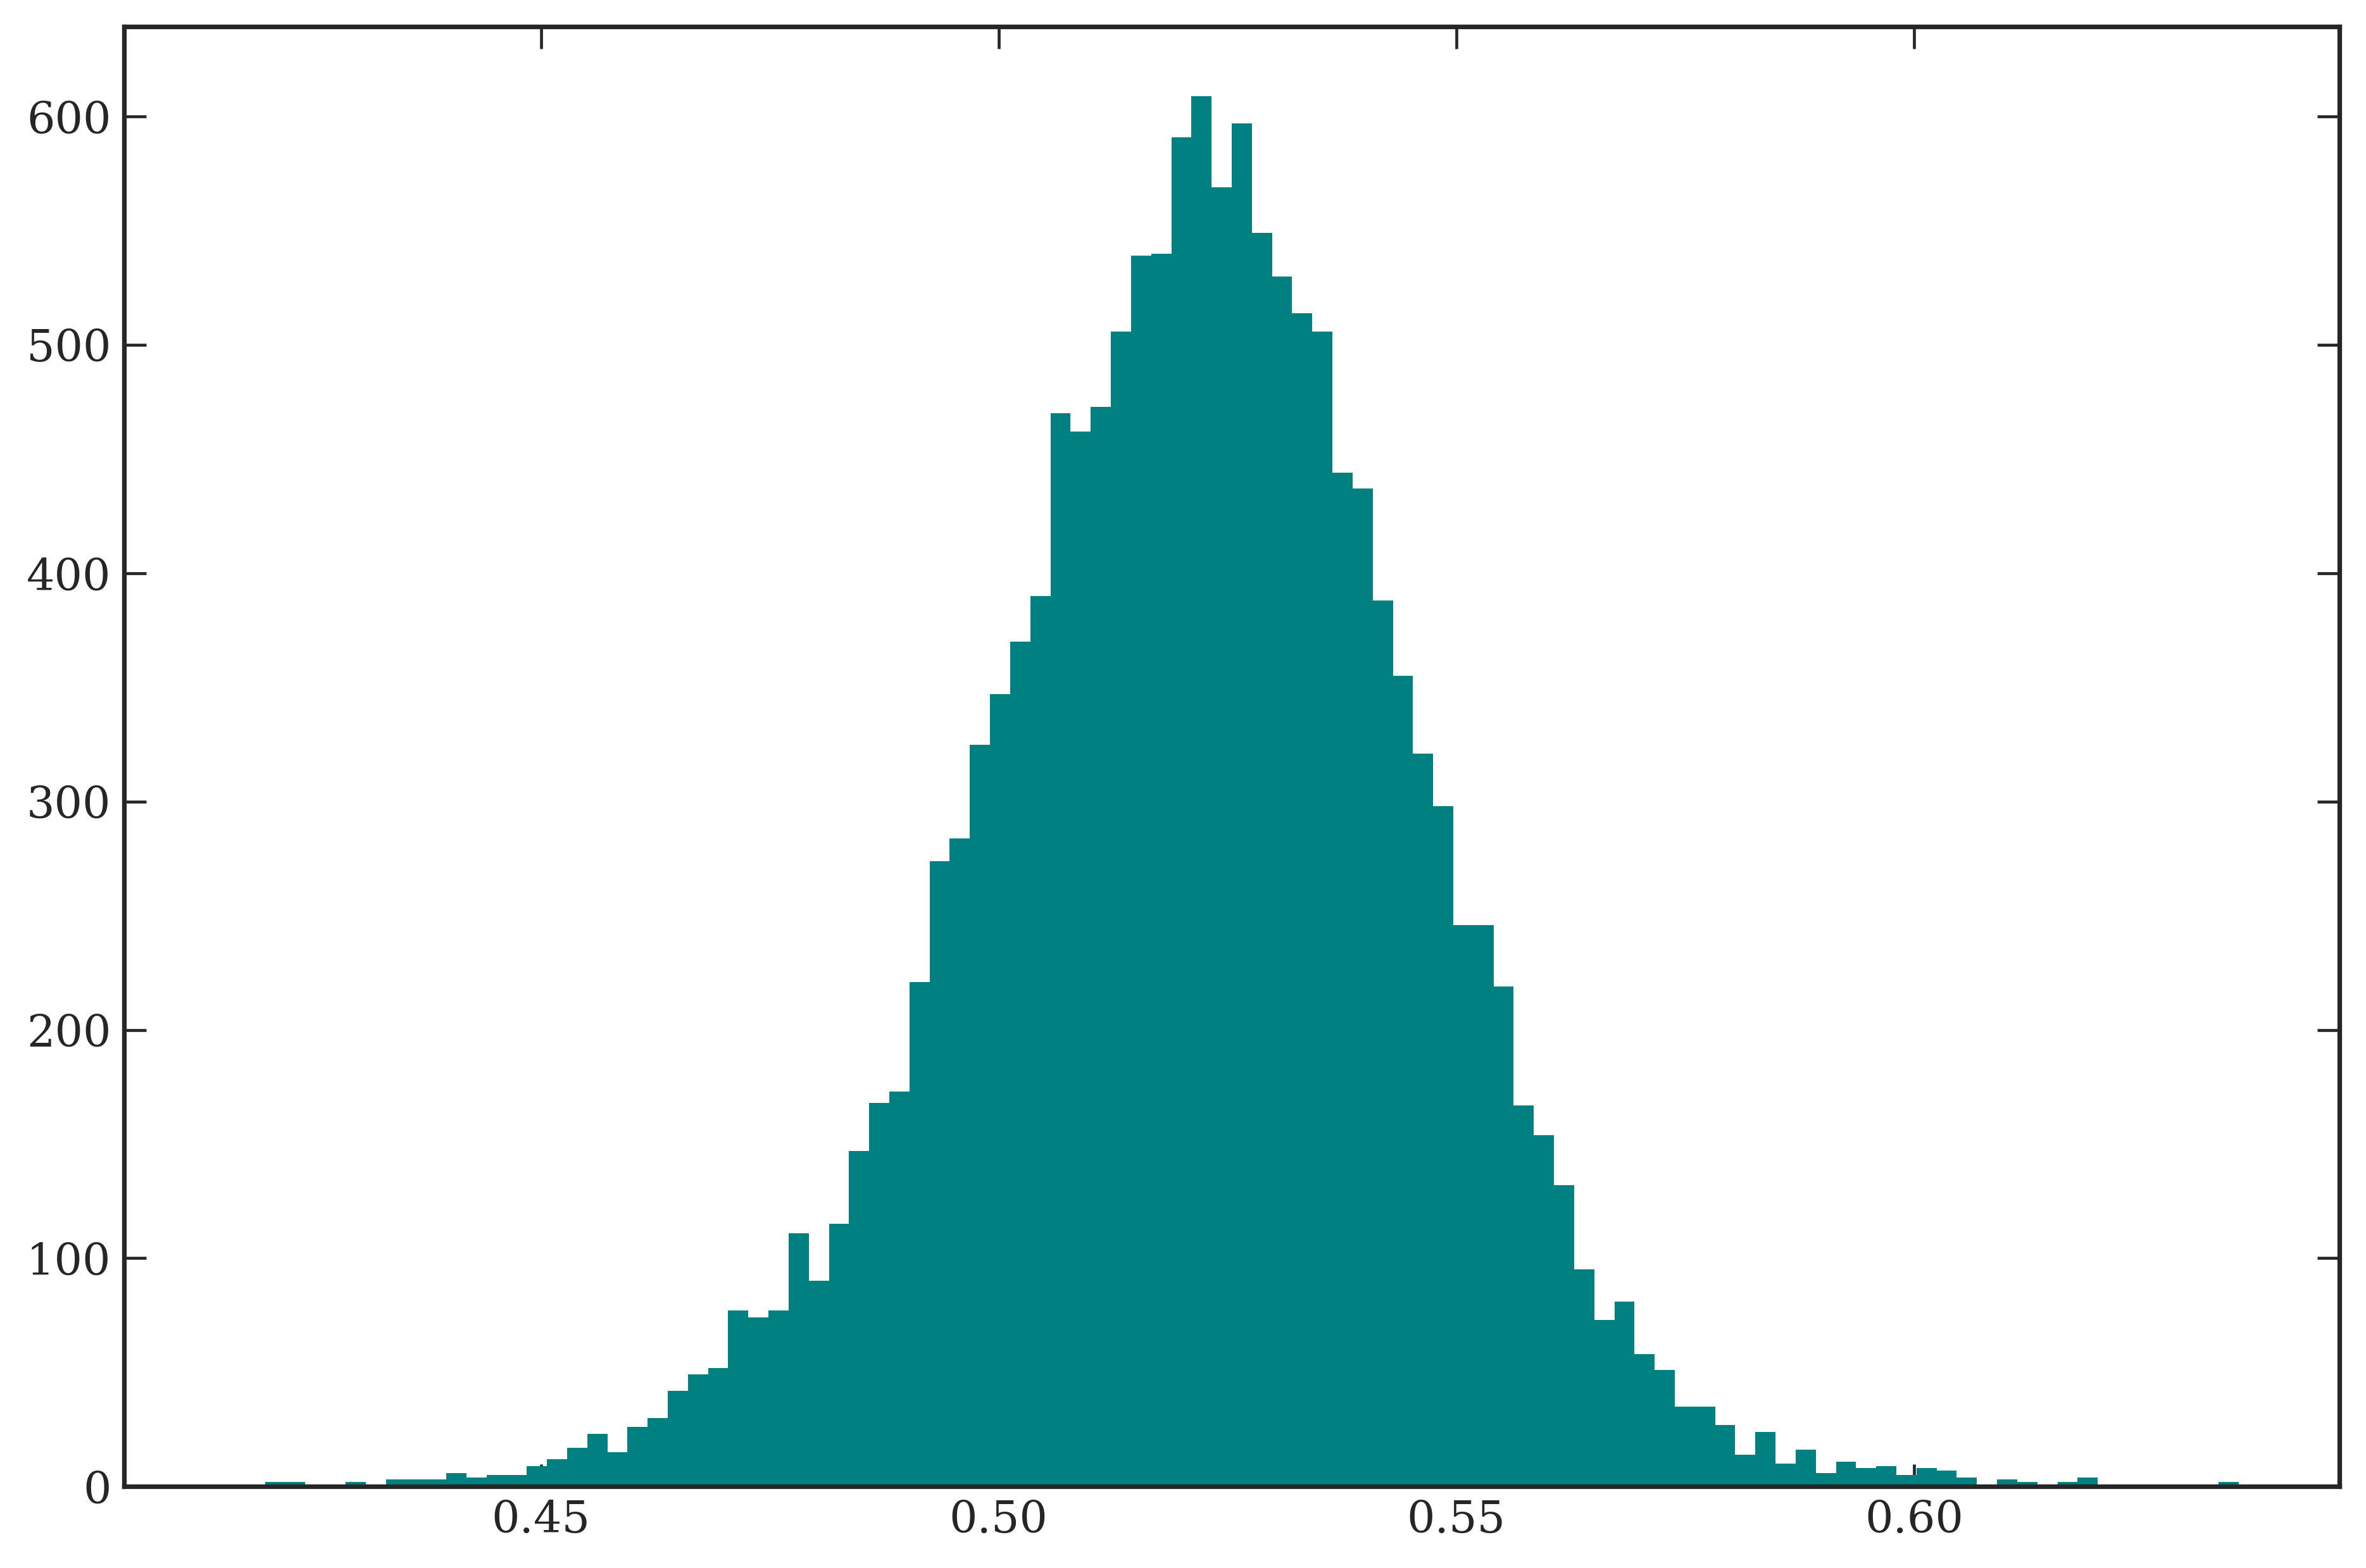

In [51]:
plt.hist((nn_arr[:,0,:] /nn_arr[:,-1,:]).flatten(), bins=100);

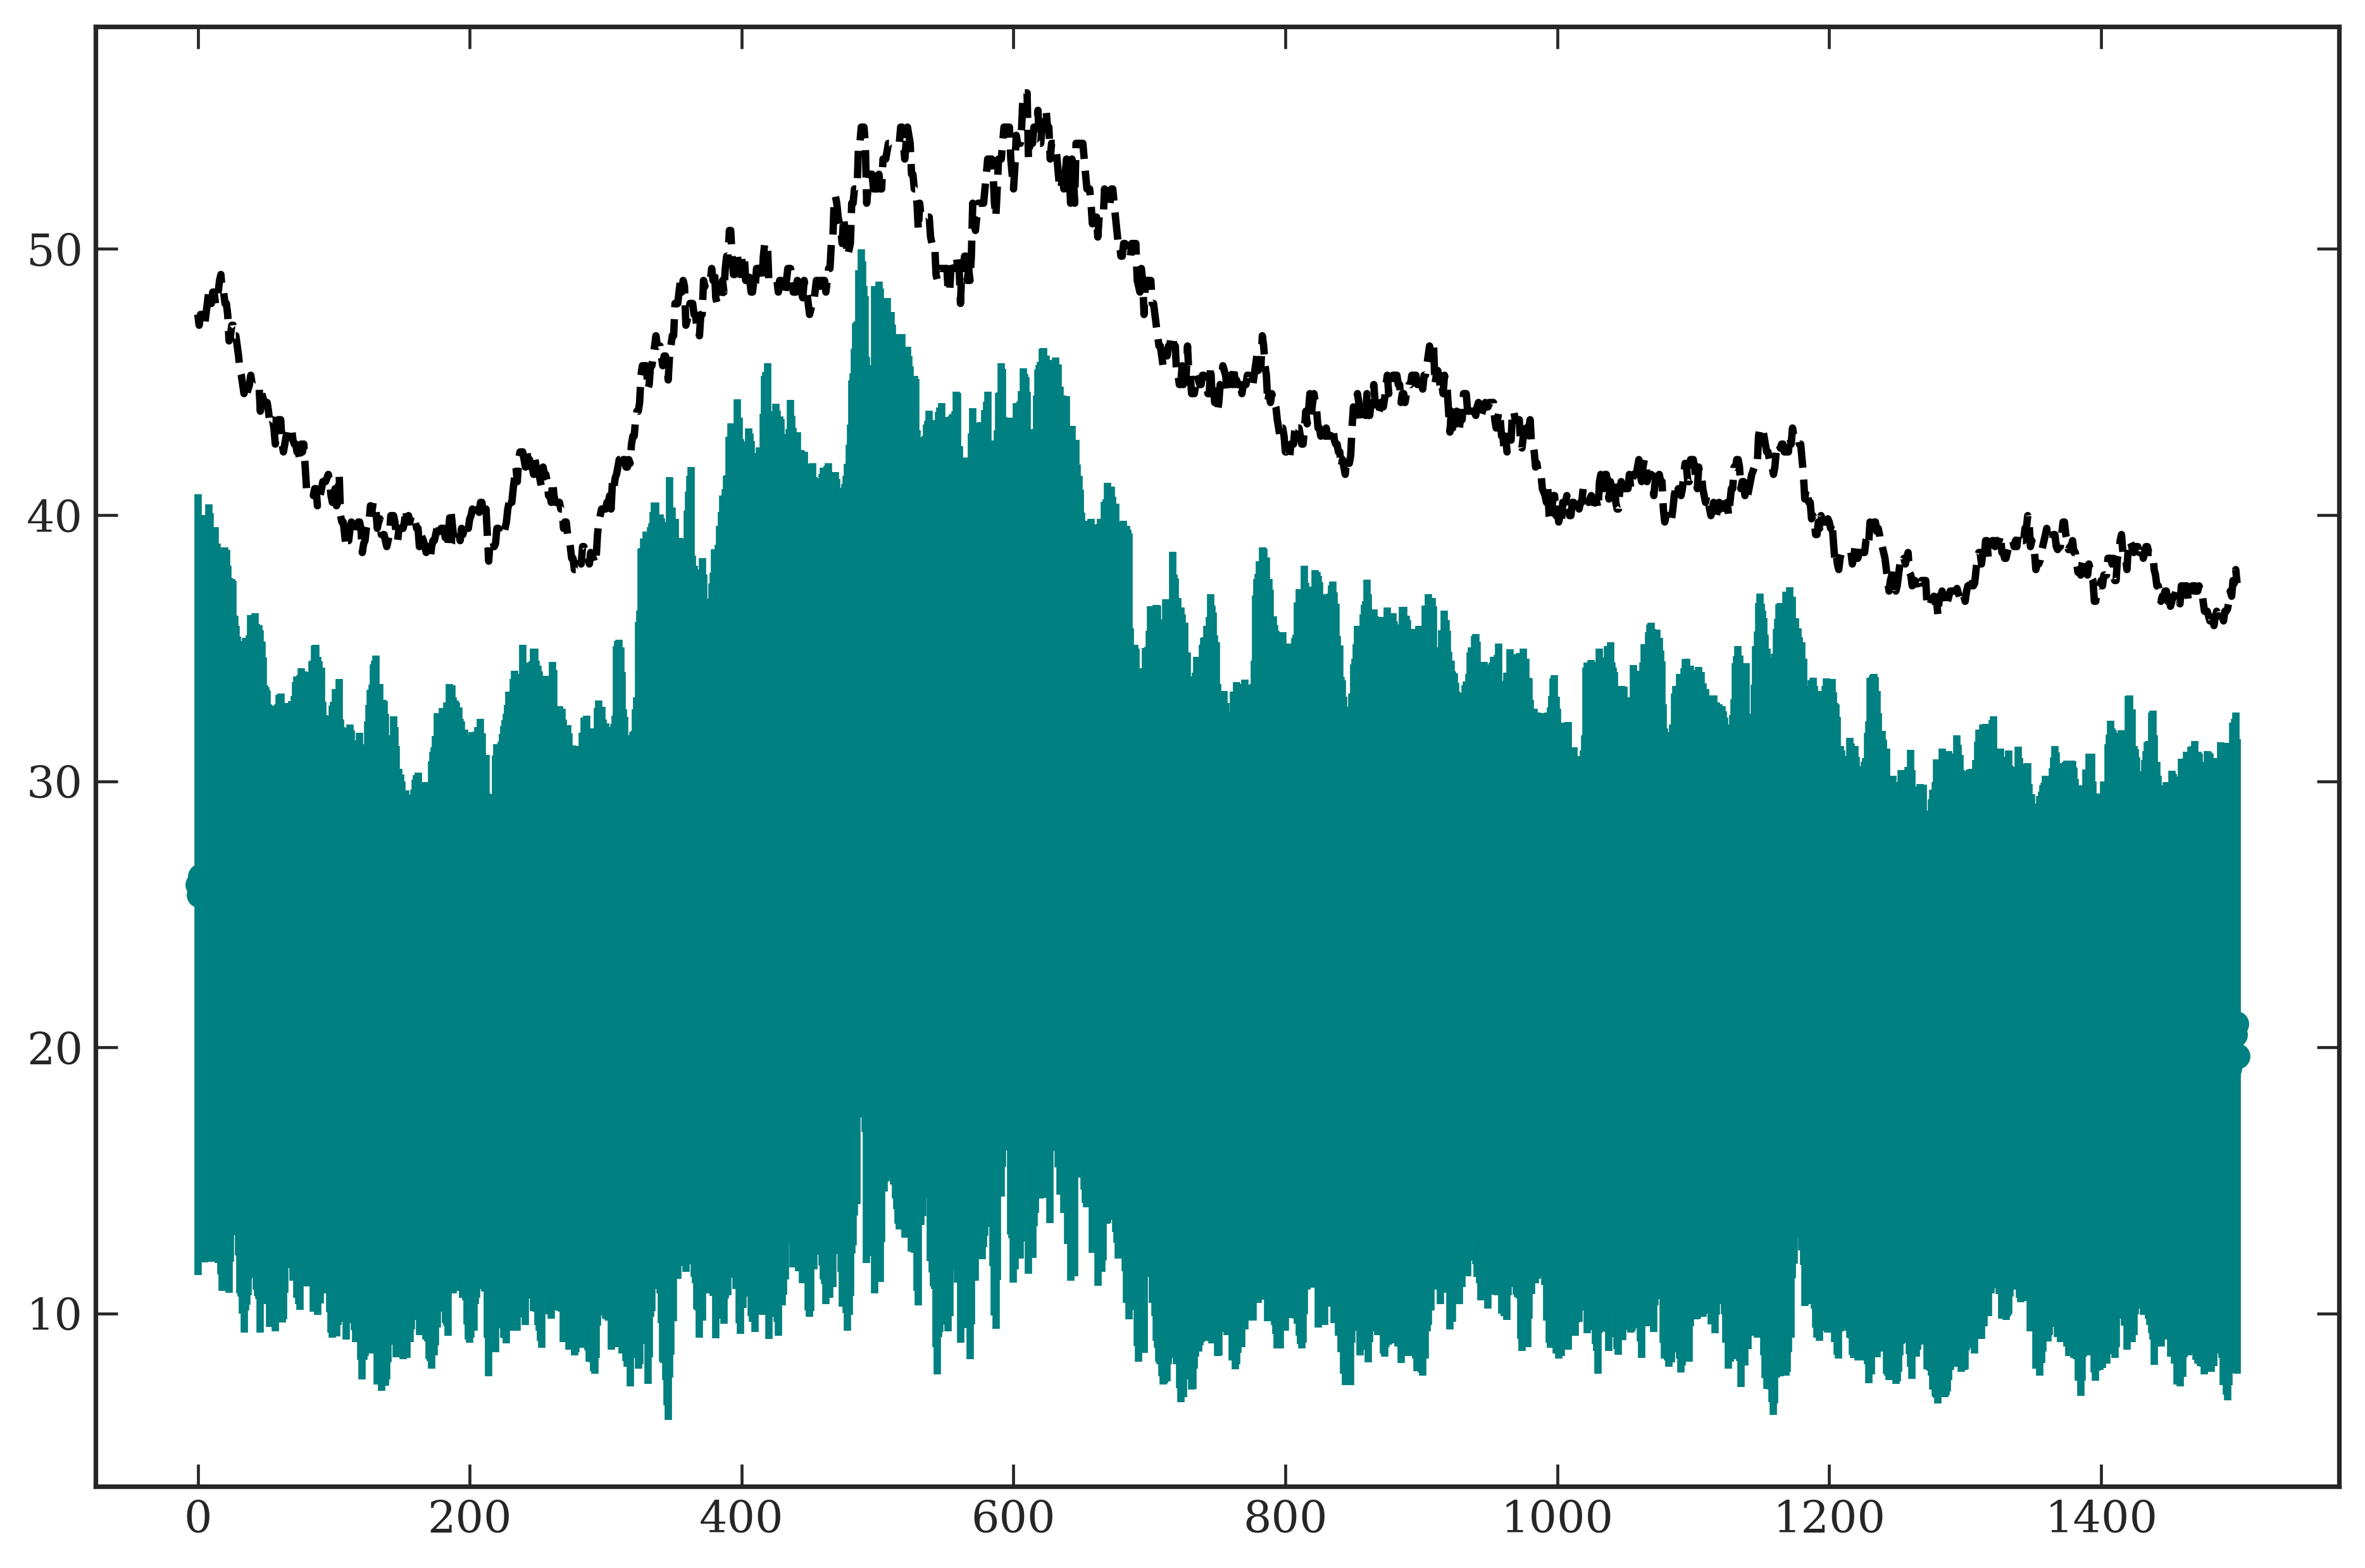

In [42]:
plt.errorbar(np.arange(len(def0)), nn_arr[:,0], yerr=nn_arr[:,1], fmt='o')
plt.plot(nn_arr[:,2], 'k--')